<a href="https://colab.research.google.com/github/mpekar1/DSS-IDI-modelling/blob/main/Markov_Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov Chain Modelling

**Objective:**
Analyse trends among individuals ceasing to receive DSS services and model the transition probabilities across different states influenced by various factors, including age transitions around 18-20 years.

## Resources

Emmanuel F. Drabo and William V. Padula, Introduction to Markov modeling In: Handbook of Applied Health Economics in
Vaccines. Edited by: David Bishai, Logan Brenzel and William V. Padula, Oxford University Press. © Oxford University Press 2023.
DOI: 10.1093/oso/9780192896087.003.0022
https://academic.oup.com/book/45888/chapter/401430223


http://cran.nexr.com/web/packages/markovchain/vignettes/markovchainCrashIntro.pdf

https://www.datacamp.com/tutorial/markov-chain-analysis-r

https://www.datacamp.com/tutorial/markov-chains-python-tutorial

https://setosa.io/ev/markov-chains/

https://cran.r-project.org/web/packages/markovchain/markovchain.pdf


## Input data created by the original codes producing descriptive statistics of the population

**Data Tables Explanation**
1. Descriptive Data Table: **[IDI_Sandpit].[DL-MAA2023-41].[202306_output1_descriptives]**
This table provides a snapshot of DSS clients for the year 2021, focusing on their demographic profiles and current status within DSS services. Each record includes:

*   snz_uid: Unique identifier for each client.
*   age_group: Age category of the client.
*   need_band_number and need_band_desc: Numerical and descriptive
*   categorisations of the client's needs
*   gender: Client's gender.
*   disability_allowance: Indicates if the client receives a disability allowance (1 for yes, 0 for no).
*   education_level: The highest level of education attained.
*   income_band: Income category.
*   employment_status: Current employment status.
*   benefit_reception: Indicates if the client is receiving any additional benefits (Yes or No).

| snz_uid | age_group | need_band_number | need_band_desc | gender | disability_allowance | education_level | income_band | employment_status | benefit_reception |
|---------|-----------|------------------|----------------|--------|----------------------|-----------------|-------------|-------------------|-------------------|
| 001     | 19-44     | 5                | 05-19          | Male   | 1                    | University      | High        | Employed          | Yes               |
| 002     | 45-64     | 20               | 20-39          | Female | 0                    | High School     | Medium      | Unemployed        | Yes               |
| 003     | 3-18      | 0                | Zero           | Female | 0                    | None            | Low         | N/A               | No                |
| 004     | 65+       | 80               | 80-99          | Male   | 1                    | College         | Low         | Retired           | No                |
| 005     | 19-44     | 1                | 01-04          | Female | 1                    | High School     | Medium      | Employed          | No                |


2.  Service Engagement Data Table: **[IDI_Sandpit].[DL-MAA2023-41].[202306_sample_input]**
This table contains entries for client engagements with DSS services:

*   snz_uid: Unique identifier for each client linked to the descriptive data.
*   age, gender, ethnicity: Demographic details.
*   disability_type: Type of disability the client has.
*   service_type: The type of DSS service the client is receiving.
*   entry_date and exit_date: Dates marking the start and potential end of service engagement.
*   status: Current status of the service engagement (Active, Exited).

| snz_uid | age | gender | ethnicity | disability_type  | service_type       | entry_date | exit_date | status |
|---------|-----|--------|-----------|------------------|--------------------|------------|-----------|--------|
| 001     | 34  | M      | European  | Cerebral Palsy   | Home Care          | 2018-01-01 | NULL      | Active |
| 002     | 22  | F      | Maori     | Autism           | Community Support  | 2017-06-01 | 2019-03-01| Exited |


## Data Preparation for Markov Chain Modelling
To prepare the data for Markov Chain Modelling, we need to consolidate and reformat the existing datasets to capture transitions between states (services) over time. This involves creating a new dataset that tracks changes in service status, type, and personal demographics year by year. The dataset will look like this:

Markov Chain Modelling Input Data Table
*   snz_uid: Unique identifier for each client.
*   year: The year of the record.
*   age: Client's age at the time of the record.
*   gender: Client's gender.
*   ethnicity: Client's ethnicity.
*   service_type: Type of service the client was receiving. However, in Markov Chain Modelling, these states are mutually exclusive and exhaustive and so each individual represented in the model can be in one and only one of these disease states at any given time.
*   entry_date and exit_date: Dates of service engagement.
*   reason_for_exit: Reason for service discontinuation (if applicable).
*   status: Status of the client in the DSS system (Active, Exited).

| snz_uid | year | age | gender | ethnicity | service_type        | entry_date  | exit_date  | reason_for_exit     | status  |
|---------|------|-----|--------|-----------|---------------------|-------------|------------|---------------------|---------|
| 001     | 2007 | 34  | M      | European  | Home Care           | 2007-01-05  | 2009-12-15 | Graduated           | Exited  |
| 002     | 2008 | 22  | F      | Maori     | Community Support   | 2008-06-10  | NULL       | NULL                | Active  |
| 003     | 2007 | 29  | M      | Pacific   | Job Training        | 2007-02-20  | 2008-03-01 | Job Found           | Exited  |
| 004     | 2009 | 18  | F      | Asian     | Education           | 2009-05-15  | 2013-06-30 | Graduated           | Exited  |
| 005     | 2010 | 45  | F      | European  | Rehabilitation      | 2010-09-01  | 2012-11-20 | Health Improvement  | Exited  |


## Initial Assumptions

### Population
This is a cohort model, i.e. it represents the experience of a simulated cohort, i.e. clients who receive (or do not receive) DSS in a certain perido of time.

### States in the Markov Model
To effectively model transitions between the states using a Markov Chain, we first need to clearly define each state, establish the conditions for transitions between them, and then collect the appropriate data to calculate the transition probabilities. Here's how we might set up your model with these states:


1. Different DSS Services:
*   Home
*   Flexible funding
*   Facility-based support
*   Early investment
2. Employment Status (categorised by plausible and meaningful income bands):
*   No income
*   0-50% of minimum wage
*   50-100% of minimum wage
*   100% of minimum wage to average wage
*   Above average wage
3. Main Benefits:
*   Job seeker
*   Parental
*   Sickness
4. Supplementary Benefit
5. In Education
6. In Healthcare Facility (hospitalized)
7. In Prison
8. Deceased (Terminal state with no outgoing transitions)
9. Overseas
10. None of the Above




In [2]:
# Load necessary libraries
library(dplyr)
library(lubridate)

# Expanded example data frame
data <- data.frame(
  snz_uid = c("001", "002", "003", "004", "005", "006", "007", "008", "009", "010", "011", "012", "013", "014", "015"),
  year = c(2007, 2008, 2007, 2009, 2010, 2007, 2008, 2007, 2009, 2010, 2007, 2008, 2007, 2009, 2010),
  service_type = c("Home Care", "Community Support", "Job Training", "Education", "Rehabilitation",
                   "Home Care", "Community Support", "Job Training", "Education", "Rehabilitation",
                   "Home Care", "Community Support", "Job Training", "Education", "Rehabilitation"),
  entry_date = c("2007-01-05", "2008-06-10", "2007-02-20", "2009-05-15", "2010-09-01",
                 "2007-03-05", "2008-07-10", "2007-04-20", "2009-06-15", "2010-10-01",
                 "2007-02-01", "2008-08-10", "2007-05-20", "2009-07-15", "2010-11-01"),
  exit_date = c("2009-12-15", NA, "2008-03-01", "2013-06-30", "2012-11-20",
                "2009-11-15", NA, "2008-02-01", "2013-05-30", "2012-10-20",
                "2009-10-15", NA, "2008-01-01", "2013-04-30", "2012-09-20"),
  status = c("Exited", "Active", "Exited", "Exited", "Exited",
             "Exited", "Active", "Exited", "Exited", "Exited",
             "Exited", "Active", "Exited", "Exited", "Exited"),
  ethnicity = c("European", "Maori", "Pacific", "Asian", "European",
                "Maori", "Pacific", "European", "Asian", "Maori",
                "Pacific", "European", "Asian", "Maori", "Pacific")
)

# Convert date columns to Date type
data$entry_date <- as.Date(data$entry_date)
data$exit_date <- as.Date(data$exit_date, tryFormats = c("%Y-%m-%d", NA))

# Define transitions based on service type and status
data <- data %>%
  mutate(
    next_service = lead(service_type, default = "End of Data"),
    transition = paste(service_type, next_service, sep = " to ")
  )

# Display the dataset to see the new columns
print(data)




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




   snz_uid year      service_type entry_date  exit_date status ethnicity
1      001 2007         Home Care 2007-01-05 2009-12-15 Exited  European
2      002 2008 Community Support 2008-06-10       <NA> Active     Maori
3      003 2007      Job Training 2007-02-20 2008-03-01 Exited   Pacific
4      004 2009         Education 2009-05-15 2013-06-30 Exited     Asian
5      005 2010    Rehabilitation 2010-09-01 2012-11-20 Exited  European
6      006 2007         Home Care 2007-03-05 2009-11-15 Exited     Maori
7      007 2008 Community Support 2008-07-10       <NA> Active   Pacific
8      008 2007      Job Training 2007-04-20 2008-02-01 Exited  European
9      009 2009         Education 2009-06-15 2013-05-30 Exited     Asian
10     010 2010    Rehabilitation 2010-10-01 2012-10-20 Exited     Maori
11     011 2007         Home Care 2007-02-01 2009-10-15 Exited   Pacific
12     012 2008 Community Support 2008-08-10       <NA> Active  European
13     013 2007      Job Training 2007-05-20 2008-0

In [3]:
# Create a transition matrix from this data
transition_matrix <- table(data$service_type, data$next_service)

# Print transition matrix with more digits
print(format(transition_matrix, digits = 4))

# Note: Replace "lead(service_type, default = "End of Data")" with appropriate logic
# to match research requirements and data structure.


                   
                    Community Support Education End of Data Home Care
  Community Support "0"               "0"       "0"         "0"      
  Education         "0"               "0"       "0"         "0"      
  Home Care         "3"               "0"       "0"         "0"      
  Job Training      "0"               "3"       "0"         "0"      
  Rehabilitation    "0"               "0"       "1"         "2"      
                   
                    Job Training Rehabilitation
  Community Support "3"          "0"           
  Education         "0"          "3"           
  Home Care         "0"          "0"           
  Job Training      "0"          "0"           
  Rehabilitation    "0"          "0"           


Based on the matrix provided:

Community Support to Job Training: 3 transitions
Education to Rehabilitation: 3 transitions
Rehabilitation to Home Care: 2 transitions
Rehabilitation to End of Data: 1 transition


In [4]:
# Assuming data has columns 'service_type' and 'next_service'
# Create a transition matrix from this data
transition_matrix <- table(data$service_type, data$next_service)

# Add row totals to the transition matrix
transition_matrix <- cbind(transition_matrix, rowSums(transition_matrix))
colnames(transition_matrix)[ncol(transition_matrix)] <- "Total Out"

# Add column totals to the transition matrix
transition_matrix <- rbind(transition_matrix, colSums(transition_matrix))
rownames(transition_matrix)[nrow(transition_matrix)] <- "Total In"

# Calculate transition probabilities as percentages
transition_probabilities <- transition_matrix[1:(nrow(transition_matrix) - 1), 1:(ncol(transition_matrix) - 1)] /
                            rowSums(transition_matrix[1:(nrow(transition_matrix) - 1), 1:(ncol(transition_matrix) - 1)])

# Replace NA values with zeros (where division by zero occurs)
transition_probabilities[is.na(transition_probabilities)] <- 0

# Convert to percentages for clarity
transition_probabilities <- round(transition_probabilities * 100, 2)

# Print matrices
print("Transition Counts (with totals):")
print(transition_matrix)

print("Transition Probabilities (%):")
print(transition_probabilities)


[1] "Transition Counts (with totals):"
                  Community Support Education End of Data Home Care
Community Support                 0         0           0         0
Education                         0         0           0         0
Home Care                         3         0           0         0
Job Training                      0         3           0         0
Rehabilitation                    0         0           1         2
Total In                          3         3           1         2
                  Job Training Rehabilitation Total Out
Community Support            3              0         3
Education                    0              3         3
Home Care                    0              0         3
Job Training                 0              0         3
Rehabilitation               0              0         3
Total In                     3              3        15
[1] "Transition Probabilities (%):"
                  Community Support Education End of Data

Transition Probabilities (%):
This matrix converts the absolute counts into probabilities (or percentages) that help understand the likelihood of transitioning from one state to another.

Values represent the percentage probability of moving from the row state to the column state.
For example, 100% of individuals in Home Care transitioned away from Home Care, with none staying or moving to other states listed.
In Rehabilitation, 33.33% led to an "End of Data" state, and 66.67% transitioned back to Home Care, indicating a high likelihood of returning to initial care after Rehabilitation.

## Model Initialisation and Simulation:
Initiate the Markov Model: Start the Markov chain model using the initial state distribution based on the most recent data available. This involves setting up the initial probabilities of each state based on the data.
Run Simulations: Use the transition probabilities to simulate the movement of individuals through different states over multiple time periods. This simulation can extend several years into the future to observe long-term trends and potential impacts of current policies.

In [5]:
# Initialise the Markov Model


# Create a transition matrix from this data
transition_matrix <- table(data$service_type, data$next_service)

# Add row totals to the transition matrix for outgoing states
transition_matrix <- cbind(transition_matrix, rowSums(transition_matrix))
colnames(transition_matrix)[ncol(transition_matrix)] <- "Total Out"

# Add column totals to the transition matrix for incoming states
transition_matrix <- rbind(transition_matrix, colSums(transition_matrix))
rownames(transition_matrix)[nrow(transition_matrix)] <- "Total In"

# Calculate transition probabilities as percentages
transition_probabilities <- sweep(transition_matrix[1:nrow(transition_matrix) - 1, 1:ncol(transition_matrix) - 1], 1,
                                  rowSums(transition_matrix[1:nrow(transition_matrix) - 1, 1:ncol(transition_matrix) - 1]), "/") * 100
transition_probabilities[is.na(transition_probabilities)] <- 0  # Replace NA with zero

# Print transition matrices
print("Transition Counts (with totals):")
print(transition_matrix)

print("Transition Probabilities (%):")
print(transition_probabilities)



[1] "Transition Counts (with totals):"
                  Community Support Education End of Data Home Care
Community Support                 0         0           0         0
Education                         0         0           0         0
Home Care                         3         0           0         0
Job Training                      0         3           0         0
Rehabilitation                    0         0           1         2
Total In                          3         3           1         2
                  Job Training Rehabilitation Total Out
Community Support            3              0         3
Education                    0              3         3
Home Care                    0              0         3
Job Training                 0              0         3
Rehabilitation               0              0         3
Total In                     3              3        15
[1] "Transition Probabilities (%):"
                  Community Support Education End of Data

In [6]:
# Calculate transition counts
transition_counts <- table(data$service_type, data$next_service)

# Convert counts to a matrix for further operations
transition_matrix <- as.matrix(transition_counts)

# Assign state names
states <- rownames(transition_matrix)

# Print transition counts matrix
print("Transition Counts Matrix:")
print(transition_matrix)

[1] "Transition Counts Matrix:"
                   
                    Community Support Education End of Data Home Care
  Community Support                 0         0           0         0
  Education                         0         0           0         0
  Home Care                         3         0           0         0
  Job Training                      0         3           0         0
  Rehabilitation                    0         0           1         2
                   
                    Job Training Rehabilitation
  Community Support            3              0
  Education                    0              3
  Home Care                    0              0
  Job Training                 0              0
  Rehabilitation               0              0


In [7]:
# Define all possible states
all_states <- unique(c(data$service_type, data$next_service))

# Create a transition matrix with all states ensuring a square matrix
transition_matrix <- table(factor(data$service_type, levels = all_states),
                           factor(data$next_service, levels = all_states))

# Print the complete transition matrix
print("Complete Transition Matrix:")
print(transition_matrix)


[1] "Complete Transition Matrix:"
                   
                    Home Care Community Support Job Training Education
  Home Care                 0                 3            0         0
  Community Support         0                 0            3         0
  Job Training              0                 0            0         3
  Education                 0                 0            0         0
  Rehabilitation            2                 0            0         0
  End of Data               0                 0            0         0
                   
                    Rehabilitation End of Data
  Home Care                      0           0
  Community Support              0           0
  Job Training                   0           0
  Education                      3           0
  Rehabilitation                 0           1
  End of Data                    0           0


In [8]:
# Convert counts to probabilities

# Normalise the transition matrix to create probabilities
transition_probabilities <- sweep(transition_matrix, 1, rowSums(transition_matrix), FUN="/")

# Replace NaN with 0 where division by zero occurs
transition_probabilities[is.na(transition_probabilities)] <- 0

# Check the probabilities matrix
print("Transition Probabilities Matrix:")
print(transition_probabilities)



[1] "Transition Probabilities Matrix:"
                   
                    Home Care Community Support Job Training Education
  Home Care         0.0000000         1.0000000    0.0000000 0.0000000
  Community Support 0.0000000         0.0000000    1.0000000 0.0000000
  Job Training      0.0000000         0.0000000    0.0000000 1.0000000
  Education         0.0000000         0.0000000    0.0000000 0.0000000
  Rehabilitation    0.6666667         0.0000000    0.0000000 0.0000000
  End of Data       0.0000000         0.0000000    0.0000000 0.0000000
                   
                    Rehabilitation End of Data
  Home Care              0.0000000   0.0000000
  Community Support      0.0000000   0.0000000
  Job Training           0.0000000   0.0000000
  Education              1.0000000   0.0000000
  Rehabilitation         0.0000000   0.3333333
  End of Data            0.0000000   0.0000000


### Simulate the Markov Chain

In [9]:
# Install the markovchain package if it's not already installed
if (!require(markovchain)) {
  install.packages("markovchain", dependencies = TRUE)
}

# Load the package
library(markovchain)


Loading required package: markovchain

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘markovchain’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘htmlwidgets’, ‘visNetwork’, ‘mvtnorm’, ‘truncnorm’, ‘coda’, ‘numDeriv’, ‘igraph’, ‘expm’, ‘Rcpp’, ‘RcppParallel’, ‘RcppArmadillo’, ‘diagram’, ‘DiagrammeR’, ‘msm’, ‘Rsolnp’, ‘ctmcd’, ‘bookdown’, ‘rticles’


Package:  markovchain
Version:  0.9.5
Date:     2023-09-24 09:20:02 UTC
BugReport: https://github.com/spedygiorgio/markovchain/issues



Attaching package: ‘markovchain’


The following object is masked from ‘package:lubridate’:

    period




In [10]:
# Force conversion of the table to a matrix
transition_probabilities_matrix <- as.matrix(transition_probabilities)

# Ensure that the result is indeed a matrix by setting the class explicitly
class(transition_probabilities_matrix) <- "matrix"


In [11]:
class(transition_probabilities_matrix)

[1] "matrix" "array"

In [12]:
# Examine the structure and content of the matrix
str(transition_probabilities_matrix)
print(transition_probabilities_matrix)


 num [1:6, 1:6] 0 0 0 0 0.667 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:6] "Home Care" "Community Support" "Job Training" "Education" ...
  ..$ : chr [1:6] "Home Care" "Community Support" "Job Training" "Education" ...
                   
                    Home Care Community Support Job Training Education
  Home Care         0.0000000                 1            0         0
  Community Support 0.0000000                 0            1         0
  Job Training      0.0000000                 0            0         1
  Education         0.0000000                 0            0         0
  Rehabilitation    0.6666667                 0            0         0
  End of Data       0.0000000                 0            0         0
                   
                    Rehabilitation End of Data
  Home Care                      0   0.0000000
  Community Support              0   0.0000000
  Job Training                   0   0.0000000
  Education                      1   0.0000000

In [14]:
# Adjust for absorbing state 'End of Data'
if (is.nan(rowSums(transition_probabilities_matrix)["End of Data"])) {
  transition_probabilities_matrix["End of Data",] <- 0
  transition_probabilities_matrix["End of Data","End of Data"] <- 1
}

# Normalize the transition matrix again in case other rows are affected
row_sums <- rowSums(transition_probabilities_matrix)
transition_probabilities_matrix <- sweep(transition_probabilities_matrix, 1, row_sums, "/")

# Check to make sure each row now sums to 1
print(rowSums(transition_probabilities_matrix))  # should all be 1



        Home Care Community Support      Job Training         Education 
                1                 1                 1                 1 
   Rehabilitation       End of Data 
                1                 1 


In [15]:

# Recreate the Markov chain object with the normalized matrix
mc <- new("markovchain", states = colnames(transition_probabilities_matrix), byrow = TRUE,
          transitionMatrix = transition_probabilities_matrix,
          name = "DSS Service Transition")

# Print the Markov chain to ensure it's correctly set up
print(mc)

                   
                    Home Care Community Support Job Training Education
  Home Care         0.0000000                 1            0         0
  Community Support 0.0000000                 0            1         0
  Job Training      0.0000000                 0            0         1
  Education         0.0000000                 0            0         0
  Rehabilitation    0.6666667                 0            0         0
  End of Data       0.0000000                 0            0         0
                   
                    Rehabilitation End of Data
  Home Care                      0   0.0000000
  Community Support              0   0.0000000
  Job Training                   0   0.0000000
  Education                      1   0.0000000
  Rehabilitation                 0   0.3333333
  End of Data                    0   1.0000000



## Simulate the Markov Chain

You can use the markovchain package to simulate the chain over multiple periods, which will provide insights into long-term state distributions and potential steady states.

a. Set Up Simulation Parameters
Decide how many time steps (periods) you want to simulate and how many paths (individual trajectories) you're interested in observing. For a comprehensive analysis, you might simulate several years into the future.

b. Run the Simulation
Use the rmarkovchain function from the markovchain package, which generates random states according to the transition probabilities.

In [37]:
# Assume 'mc' is your Markov chain object from previous steps
num_periods <- 20  # Number of time periods to simulate
num_simulations <- 1000  # Number of individual paths to simulate

# Simulate the Markov chain
simulations <- replicate(num_simulations, {
  rmarkovchain(n = num_periods, object = mc, t0 = "Home Care")
})

### Analyse the Simulation Results

State Distribution Over Time: Analyze how the distribution of states evolves over the simulation period. This will help in understanding how often individuals remain in specific services or transition to others.
Identify Common Pathways: From the simulation, determine common pathways through the states, which can help identify typical or atypical service usage patterns.

In [38]:
# Convert simulations into a more analysable structure
simulations_df <- as.data.frame(t(simulations))

# Calculate the frequency of states at each time step
state_distribution <- apply(simulations_df, 2, function(column) {
  prop.table(table(column))
})

# Convert to dataframe for plotting
state_distribution_df <- as.data.frame(state_distribution)

print(state_distribution_df)

          V1.column V1.Freq    V2.column V2.Freq V3.column V3.Freq
1 Community Support       1 Job Training       1 Education       1
2 Community Support       1 Job Training       1 Education       1
       V4.column V4.Freq   V5.column V5.Freq         V6.column V6.Freq
1 Rehabilitation       1 End of Data   0.326 Community Support   0.674
2 Rehabilitation       1   Home Care   0.674       End of Data   0.326
     V7.column V7.Freq   V8.column V8.Freq      V9.column V9.Freq  V10.column
1  End of Data   0.326   Education   0.674    End of Data   0.326 End of Data
2 Job Training   0.674 End of Data   0.326 Rehabilitation   0.674   Home Care
  V10.Freq        V11.column V11.Freq   V12.column V12.Freq  V13.column
1    0.544 Community Support    0.456  End of Data    0.544   Education
2    0.456       End of Data    0.544 Job Training    0.456 End of Data
  V13.Freq     V14.column V14.Freq  V15.column V15.Freq        V16.column
1    0.456    End of Data    0.544 End of Data    0.702 Commun

In [39]:
# Create a clean and properly structured data frame
state_distribution_df <- data.frame(Time = rep(1:num_periods, each = num_simulations),
                                    State = as.vector(t(simulations)),
                                    Simulation = rep(1:num_simulations, times = num_periods))

# Calculate the proportion of each state at each time step
library(dplyr)
state_distribution_df <- state_distribution_df %>%
  group_by(Time, State) %>%
  summarise(Count = n(),
            .groups = 'drop') %>%
  mutate(Proportion = Count / num_simulations)

# Check the structure
print(head(state_distribution_df))


# A tibble: 6 × 4
   Time State             Count Proportion
  <int> <chr>             <int>      <dbl>
1     1 Community Support  1000      1    
2     2 Job Training       1000      1    
3     3 Education          1000      1    
4     4 Rehabilitation     1000      1    
5     5 End of Data         326      0.326
6     5 Home Care           674      0.674


### Visualise the Results

Time Series Plot: Visualize how the proportion of individuals in each state changes over time.
Sankey Diagram: To visually represent the movement between states, a Sankey diagram can be very illustrative.

In [40]:
# Install necessary packages if not already installed
if (!require("ggplot2")) install.packages("ggplot2", dependencies = TRUE)
if (!require("reshape2")) install.packages("reshape2", dependencies = TRUE)

# Load the packages
library(ggplot2)
library(reshape2)


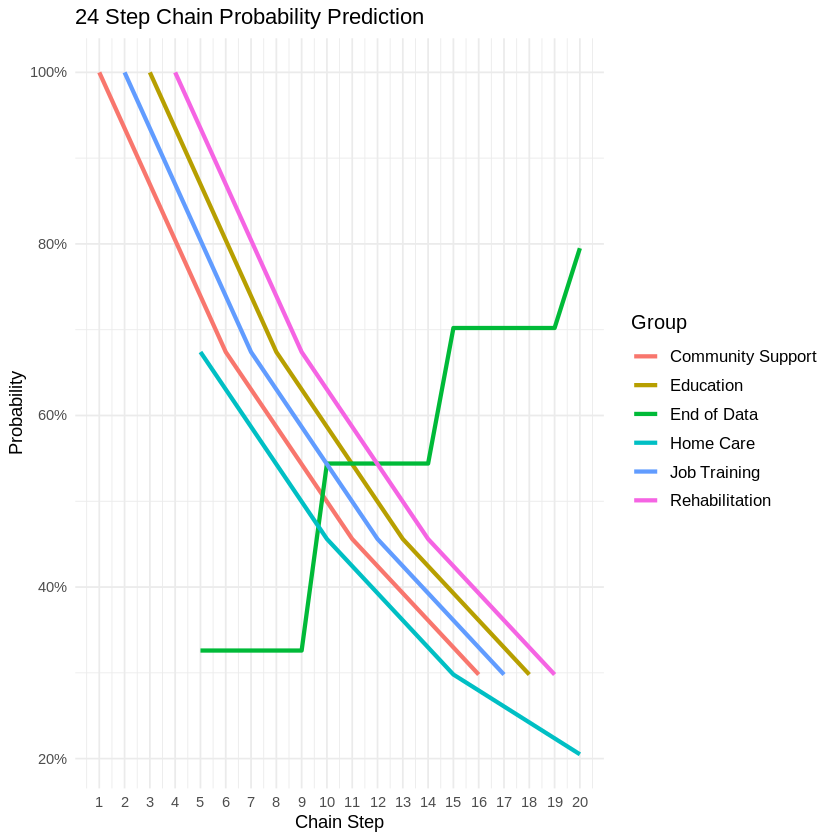

In [41]:
# Plotting  for better visual representation

ggplot(state_distribution_df, aes(x = Time, y = Proportion, color = State, group = State)) +
  geom_line(linewidth = 1.2) +  # Thicker line size for better visibility
  scale_x_continuous(breaks = seq(min(state_distribution_df$Time), max(state_distribution_df$Time), by = 1)) +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "24 Step Chain Probability Prediction",
       x = "Chain Step",
       y = "Probability",
       color = "Group") +
  theme_minimal() +
  theme(legend.title = element_text(size = 12),  # Adjust legend title size
        legend.text = element_text(size = 10))  # Adjust legend text size



The graph shows the probabilities for individuals transitioning between different states (like Community Support, Education, Home Care, etc.) over a period of 20 steps.
Each line represents a state, and the y-value at any point on that line represents the probability of an individual being in that state at that time step.
For states with probabilities that increase suddenly (e.g., the green line for "End of Data"), it suggests that external factors or the inherent nature of transitions lead to sudden increases in these states.
Declining lines indicate a decreasing likelihood of remaining in or transitioning to that state as time progresses.

### Calculating Probabilities After 20 Time Periods:

We can use the transition matrix raised to the power of 20 to find the probabilities of being in each state after 20 periods, starting from a given initial state distribution.
The process involves multiplying the transition matrix by itself 20 times (or using matrix exponentiation) and then applying the initial state distribution to this matrix.

In [74]:
# Initial state distribution, example: equally likely to start in any state

# Define the initial state distribution, for example, equally likely to start in any state
initialState <- matrix(rep(1 / length(mc@states), length(mc@states)), nrow = 1)
colnames(initialState) <- mc@states

# Calculate the state distribution after 20 steps
# Ensure the Markov chain power operation is handled correctly
futureStateMatrix <- mc^20
futureState <- initialState %*% futureStateMatrix@transitionMatrix

# Print the probabilities
print(futureState)

      
        Home Care Community Support Job Training  Education Rehabilitation
  [1,] 0.03292181        0.03292181   0.03292181 0.03292181     0.03292181
      
       End of Data
  [1,]   0.8353909


In [75]:
print(class(initialState))
print(class(mc))

[1] "matrix" "array" 
[1] "markovchain"
attr(,"package")
[1] "markovchain"


In [84]:
 library(diagram)



Loading required package: shape



In [92]:
# Transpose the transition probability matrix

tmc_matrix <- t(mc@transitionMatrix)

print(tmc_matrix)

                   
                    Home Care Community Support Job Training Education
  Home Care                 0                 0            0         0
  Community Support         1                 0            0         0
  Job Training              0                 1            0         0
  Education                 0                 0            1         0
  Rehabilitation            0                 0            0         1
  End of Data               0                 0            0         0
                   
                    Rehabilitation End of Data
  Home Care              0.6666667           0
  Community Support      0.0000000           0
  Job Training           0.0000000           0
  Education              0.0000000           0
  Rehabilitation         0.0000000           0
  End of Data            0.3333333           1


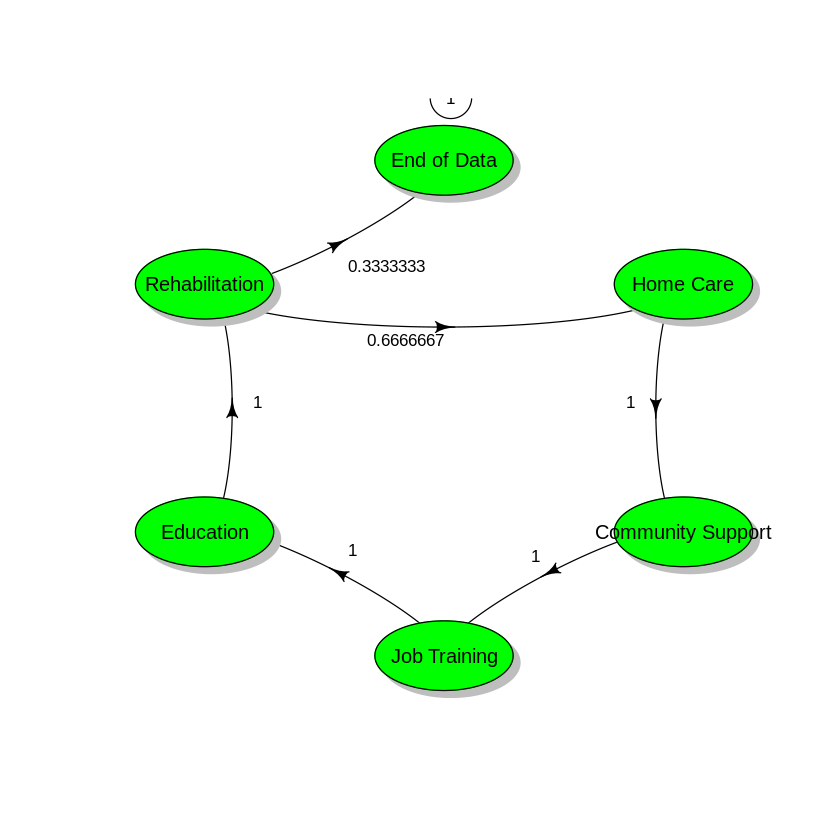

In [93]:
plotmat(tmc_matrix, arr.length=0.3, arr.width=0.15,
box.col="green", box.lwd=1, box.prop=0.5, box.size=0.1,
box.type="circle", cex.txt=0.85, lwd=1, self.cex=0.3,
self.shiftx=0.01, self.shifty=0.09)

